In [1]:
import os

if not os.path.exists("VoxCeleb_gender"):
    !pip install gdown pydub librosa
    !gdown https://drive.google.com/uc?id=1V3lNnSDv71AJYIj71V4_xD0ir0DrXxEV
    !tar -xf VoxCeleb_gender.zip #!tar -xf VoxCeleb_gender.zip
    !del VoxCeleb_gender.zip     #!del

else:
    print("Dataset already downloaded.")

Dataset already downloaded.


In [2]:
import librosa
import scipy.signal as ss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

def extract_mfcc(file_path, n_mfcc=12, win_length=320, hop_length=160):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    if sr != 16000:
        wave = librosa.resample(wave, sr, 16000)
    mfcc = librosa.feature.mfcc(y=wave, sr=16000, n_mfcc=n_mfcc, window=ss.windows.hamming, win_length=win_length, hop_length=hop_length)
    return mfcc

# Build data in memory

In [3]:
mfcc_coeff_amount = 24
window_length = int(16000*0.02)

In [4]:
arr = []
if not os.path.exists(f"mfcc_{mfcc_coeff_amount}_{window_length}.pkl"):

    aux = []

    for (dirpath, dirnames, filenames) in os.walk("VoxCeleb_gender"):
        for filename in filenames:
            if filename.endswith(".wav"):
                filepath = dirpath + "/" + filename
                aux.append({"file": filepath, "gender": "females" if "females" in dirpath else "males"})

    df = pd.DataFrame(aux)

    df["mfcc"] = pd.Series(name="mfcc", dtype=object)

    for i in range(len(df)):
        mfcc_coeffs = extract_mfcc(df.loc[i, "file"], n_mfcc=mfcc_coeff_amount, win_length=window_length)
        for i, coeffs in enumerate(mfcc_coeffs):
            if np.linalg.norm(coeffs) < 1:
                mfcc_coeffs.pop(i)
        arr.append(mfcc_coeffs)
    df["mfcc"] = arr
    df.to_pickle(f"mfcc_{mfcc_coeff_amount}_{window_length}.pkl")
else:
    print("File Found")
    df = pd.read_pickle(f"mfcc_{mfcc_coeff_amount}_{window_length}.pkl")


num_males = len(df.loc[df.gender == "males"] )           
num_females = len(df.loc[df.gender == "females"] )              

File Found


In [5]:
print("Number of males: ", num_males)
print("Number of females: ", num_females)

Number of males:  3682
Number of females:  2311


In [6]:
display(df) #Cada fila tiene los datos de un audio, cada columna mfcc contiene n_mfcc x timesteps 

,file,gender,mfcc
0,VoxCeleb_gender/males/2067.wav,males,"[[-478.53528, -459.50067, -454.37323, -453.799..."
1,VoxCeleb_gender/males/3436.wav,males,"[[-364.4941, -336.15237, -331.1945, -331.9108,..."
2,VoxCeleb_gender/males/952.wav,males,"[[-379.75958, -377.99985, -384.4355, -409.9080..."
3,VoxCeleb_gender/males/920.wav,males,"[[-590.7042, -599.7578, -625.10205, -613.7978,..."
4,VoxCeleb_gender/males/3277.wav,males,"[[-163.64647, -193.33449, -166.30594, -163.021..."
...,...,...,...
5988,VoxCeleb_gender/females/396.wav,females,"[[-280.3726, -254.26328, -266.97034, -255.1885..."
5989,VoxCeleb_gender/females/1239.wav,females,"[[-301.9855, -270.2528, -297.23227, -305.43774..."
5990,VoxCeleb_gender/females/136.wav,females,"[[-396.32053, -393.2348, -391.1963, -403.0387,..."
5991,VoxCeleb_gender/females/1563.wav,females,"[[-218.55516, -289.2457, -299.86298, -319.1746..."


In [7]:
from sklearn.model_selection import train_test_split

#Equalize number of gender in dataset
# gender_counts = df['gender'].value_counts()
# difference = abs(gender_counts['males'] - gender_counts['females'])
# if gender_counts['males'] > gender_counts['females']:
#     df_balanced = df.drop(df[df['gender'] == 'males'].sample(n=difference, random_state=42).index)
# else:
#     df_balanced = df.drop(df[df['gender'] == 'females'].sample(n=difference, random_state=42).index)

#Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(df.drop(['gender'], axis=1), df['gender'], test_size=0.2)
X_file, X_test_file = X_train["file"], X_test["file"]
X_train.drop(["file"], inplace=True, axis=1)
X_test.drop(["file"], inplace=True, axis=1)


# EDA

In [8]:
# Get the mean mfcc coefficients for each class
mean_mfcc_males = 0
mean_mfcc_females = 0

for person in df.iterrows():
    for i in range(len(person[1]["mfcc"])//mfcc_coeff_amount):
        if person[1]["gender"] == "males":
            mean_mfcc_males = np.mean(np.array(person[1]["mfcc"]), axis=1)/num_males
        else:
            mean_mfcc_females = np.mean(person[1]["mfcc"], axis=1)/num_females

display(mean_mfcc_males)
display(mean_mfcc_females)

array([-0.12125763,  0.03831061,  0.00078311,  0.0030594 , -0.00075525,
       -0.00380383, -0.00460804, -0.00234465, -0.0019011 , -0.00189399,
       -0.0015259 , -0.0005911 , -0.00054401,  0.000317  , -0.00081993,
       -0.00111976, -0.00197527, -0.00138644, -0.00207738, -0.00068184,
       -0.00142381, -0.00184187, -0.00143383, -0.0002426 ], dtype=float32)

array([-0.07018605,  0.04628376, -0.00373976,  0.00133373,  0.00072123,
       -0.00388174, -0.00209926, -0.00356676,  0.00096796,  0.0009627 ,
       -0.00219321, -0.00176692, -0.00110256, -0.00335793, -0.00324651,
       -0.00204183, -0.00338629, -0.00131157, -0.00149017, -0.00094213,
       -0.00058416,  0.00047061, -0.00123306,  0.0003224 ], dtype=float32)

In [9]:
score_males = []
score_females = []

for i in range(1000):
    score_males.append(np.sum(df.mfcc[df.gender=="males"][i], axis=1) @ mean_mfcc_males)
    score_females.append(np.sum(df.mfcc[df.gender=="females"][i + num_males], axis=1) @ mean_mfcc_males)


(array([350., 426., 119.,  49.,  23.,  11.,   5.,   4.,   3.,   3.,   3.,
          0.,   1.,   0.,   0.,   0.,   1.,   1.,   0.,   1.]),
 array([  5159.90136719,  22230.51171875,  39301.12109375,  56371.73046875,
         73442.34375   ,  90512.953125  , 107583.5625    , 124654.171875  ,
        141724.78125   , 158795.390625  , 175866.        , 192936.609375  ,
        210007.21875   , 227077.828125  , 244148.4375    , 261219.046875  ,
        278289.65625   , 295360.25      , 312430.875     , 329501.46875   ,
        346572.09375   ]),
 <BarContainer object of 20 artists>)

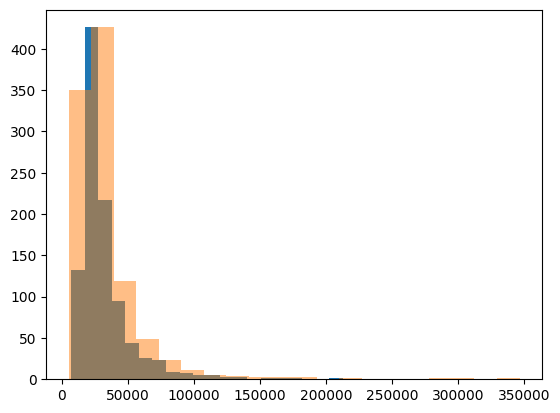

In [10]:
plt.hist(score_males, bins=20)
plt.hist(score_females, bins=20, alpha=0.5)

# GMM Model

In [11]:
amount = 50
X_male = np.concatenate(X_train.mfcc[y_train=="males"].to_numpy(), axis=1).T
X_female = np.concatenate(X_train.mfcc[y_train=="females"].to_numpy(), axis=1).T
X_test_male = np.concatenate(X_test.mfcc[y_test=="males"].to_numpy(), axis=1).T
X_test_female = np.concatenate(X_test.mfcc[y_test=="females"].to_numpy(), axis=1).T

In [12]:
X_test[y_test=="females"]

,mfcc
5613,"[[-538.49945, -481.2995, -418.71967, -297.5565..."
5871,"[[-380.82654, -344.97723, -342.65427, -338.011..."
4991,"[[-383.24484, -404.84885, -453.48642, -432.525..."
4618,"[[-254.26733, -277.07333, -271.04257, -254.477..."
5155,"[[-519.4441, -468.87677, -429.8194, -396.15714..."
...,...
3708,"[[-191.4107, -297.40503, -294.16077, -297.8175..."
4675,"[[-368.2788, -330.77322, -320.7877, -285.87234..."
5238,"[[-404.75842, -485.40582, -516.07874, -531.146..."
5635,"[[-188.30138, -220.81299, -209.44154, -205.080..."


In [14]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
import pickle


if not os.path.exists(f"gmm_male_mfcc_{mfcc_coeff_amount}_{window_length}.pkl"):
    
    gmm_male = GaussianMixture(n_components=mfcc_coeff_amount, covariance_type='full', max_iter=1000)
    gmm_female = GaussianMixture(n_components=mfcc_coeff_amount, covariance_type='full', max_iter=1000)

    gmm_male.fit(X_male)
    gmm_female.fit(X_female)

    with open(f"gmm_male_mfcc_{mfcc_coeff_amount}_{window_length}.pkl",'wb') as f:
        pickle.dump(gmm_male,f)

    with open(f"gmm_female_mfcc_{mfcc_coeff_amount}_{window_length}.pkl",'wb') as f:
        pickle.dump(gmm_female,f)

else:
    print("File Found")

    with open(f"gmm_male_mfcc_{mfcc_coeff_amount}_{window_length}.pkl",'rb') as f:
        gmm_male = pickle.load(f)

    with open(f"gmm_female_mfcc_{mfcc_coeff_amount}_{window_length}.pkl",'rb') as f:
        gmm_female = pickle.load(f)

File Found


/home/gullino18/.pyenv/versions/3.9.16/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator GaussianMixture from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [15]:
def predict_male(features):
    score = gmm_male.score_samples(features).mean() - gmm_female.score_samples(features).mean()
    return f"male?: {score>0}, score: {score}"

(array([0.00176027, 0.00088014, 0.00264041, 0.00440068, 0.00440068,
        0.01408216, 0.01320203, 0.03520541, 0.06953068, 0.07217108,
        0.07657176, 0.05896906, 0.02728419, 0.01320203, 0.00088014,
        0.        , 0.        , 0.00088014, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

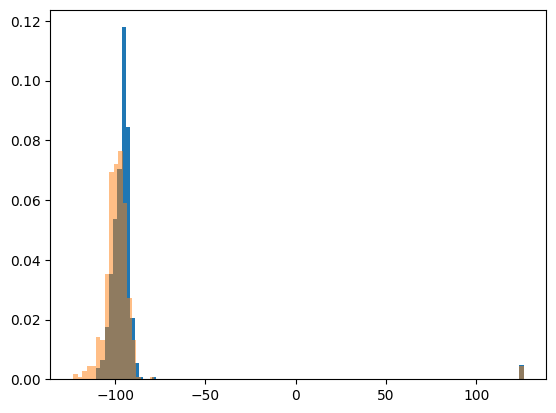

In [16]:
# Lo importante de estos scores es cuanto suman
person = 1
plt.hist(gmm_female.score_samples(X_test.mfcc.iloc[person].T), bins=100, density = True)
plt.hist(gmm_male.score_samples(X_test.mfcc.iloc[person].T), bins=100, density = True, alpha=0.5)

In [17]:
scores_fgmm = pd.Series(index=y_test.index)
scores_mgmm = pd.Series(index=y_test.index)

for index, row in X_test.iterrows():
    mfcc = row['mfcc']
    scores_fgmm[index] = gmm_female.score_samples(mfcc.T).mean()
    scores_mgmm[index] = gmm_male.score_samples(mfcc.T).mean()

/tmp/ipykernel_30303/3693417576.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores_fgmm = pd.Series(index=y_test.index)
/tmp/ipykernel_30303/3693417576.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores_mgmm = pd.Series(index=y_test.index)


In [18]:
display(scores_fgmm[y_test == "males"].mean())
display(scores_fgmm[y_test == "females"].mean())

-96.25052028606348

-95.65485153529147

(array([0.00688366, 0.00688366, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00688366, 0.        , 0.00688366,
        0.        , 0.        , 0.01376731, 0.        , 0.        ,
        0.01376731, 0.02065097, 0.        , 0.00688366, 0.01376731,
        0.00688366, 0.01376731, 0.        , 0.01376731, 0.01376731,
        0.01376731, 0.00688366, 0.        , 0.02065097, 0.02065097,
        0.01376731, 0.03441828, 0.02753462, 0.05506925, 0.03441828,
        0.04130193, 0.04818559, 0.02753462, 0.09637118, 0.06883656,
        0.10325483, 0.0619529 , 0.06883656, 0.09637118, 0.11702215,
        0.08948752, 0.19962601, 0.07572021, 0.16520774, 0.16520774,
        0.13767311, 0.19962601, 0.16520774, 0.21339333, 0.19274236,
        0.19962601, 0.22716064, 0.19274236, 0.1858587 , 0.15832408,
        0.17209139, 0.19274236, 0.16520774, 0.10325483, 0.08948752,
        0.06883656, 0.08948752, 0.11013849, 0.06883656, 0.07572021,
        0.06883656, 0.06883656, 0.03441828, 0.01

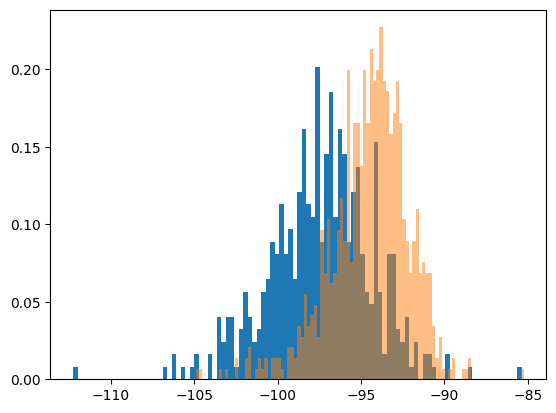

In [19]:
plt.figure()
plt.hist(scores_mgmm[y_test == "females"][:1000], bins=100, density = True)
plt.hist(scores_mgmm[y_test == "males"][:1000], bins=100, density = True, alpha=0.5)


In [20]:
predictions = []
for index in y_test.index:
    if scores_mgmm[index] > scores_fgmm[index]:
        predictions.append('males')
    else:
        predictions.append('females')

# Convert predictions to a pandas Series
predictions = pd.Series(predictions, index=y_test.index)

# Calculate the accuracy
accuracy = (predictions == y_test).mean()

# Print the accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 95.75%


# Busqueda de hiperparametros

In [21]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


def gmm_bic_score(estimator, X):
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(8, 13),
    "covariance_type": ["full", "tied", "diag", "spherical"],
}

grid_search = GridSearchCV(GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score)
grid_search.fit(X_male)

KeyboardInterrupt: 

In [22]:
import pandas as pd

df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [23]:
import seaborn as sns

sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

ValueError: Could not interpret value `Number of components` for `x`. An entry with this name does not appear in `data`.

In [26]:
import pyaudio
from IPython.display import update_display

Chunk = 1024 * 8
format = pyaudio.paFloat32
channels = 1
rate = 16000

In [28]:
p = pyaudio.PyAudio()

stream = p.open(
    format=format,
    channels=channels,
    rate=rate,
    input=True,
    output=True,
    frames_per_buffer=Chunk,
)
result = "male"
display(result, display_id="res")
while True:
    data = stream.read(Chunk)
    data_int = np.frombuffer(data, dtype=np.float32)
    features = librosa.feature.mfcc(y=data_int, sr=16000, n_mfcc=mfcc_coeff_amount, window=ss.windows.hamming, win_length=window_length, hop_length=window_length//2).T
    update_display(predict_male(features), display_id="res")



'male?: True, score: 0.433222464375433'